In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, Lasso
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, KFold

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score, recall_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

import time
import datetime

from sklearn.feature_selection import RFE, RFECV
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import lightgbm as lgb
import sqlite3 as sql

Using TensorFlow backend.
/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [33]:
conn=sql.connect('FPA_FOD_20170508.sqlite')

In [34]:
df=pd.read_sql("SELECT * from FIRES", conn)

In [35]:
print(df.shape)
df.head()

(1880465, 39)


,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


In [36]:
df.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')

In [37]:
df_orig=df.copy()

In [38]:
def secondOfDay(x):
    if x!=None:
        return (datetime.datetime.strptime(x,'%H%M')-datetime.datetime.strptime('0000','%H%M')).seconds
    else:
        return 0


In [39]:
df[df['DISCOVERY_TIME'].isnull()][['FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE']].shape

(882638, 13)

In [40]:
df['DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df['TIME_DISCOVERED'] = df['DISCOVERY_TIME'].apply(lambda x: secondOfDay(x))
df['MONTH'] = pd.DatetimeIndex(df['DATE']).month
df['DAY_OF_WEEK'] = df['DATE'].dt.weekday_name

In [121]:
df.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape', 'DATE', 'TIME_DISCOVERED', 'MONTH',
       'DAY_OF_WEEK'],
      dtype='object')

In [49]:
causes=df.groupby(df.STAT_CAUSE_DESCR)['OBJECTID'].count()

In [38]:
causes.head()

STAT_CAUSE_DESCR
Arson             281455
Campfire           76139
Children           61167
Debris Burning    429028
Equipment Use     147612
Name: OBJECTID, dtype: int64

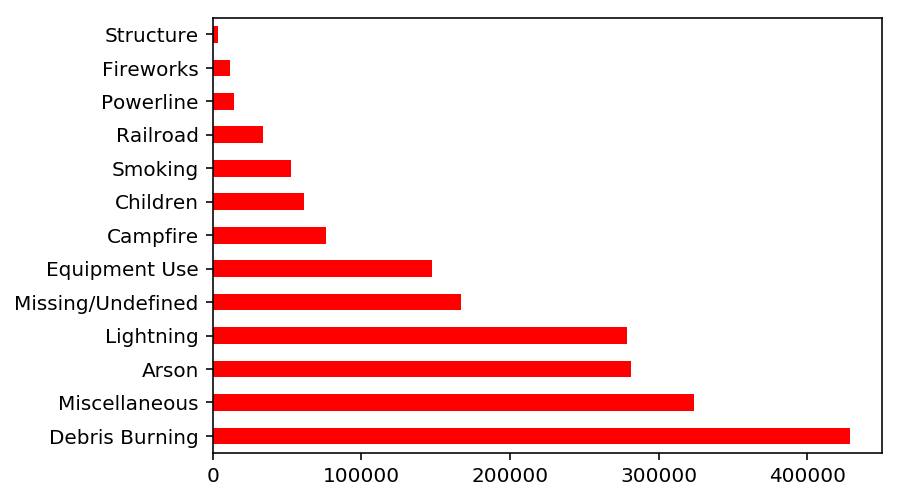

In [127]:
df['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='red')
plt.show()

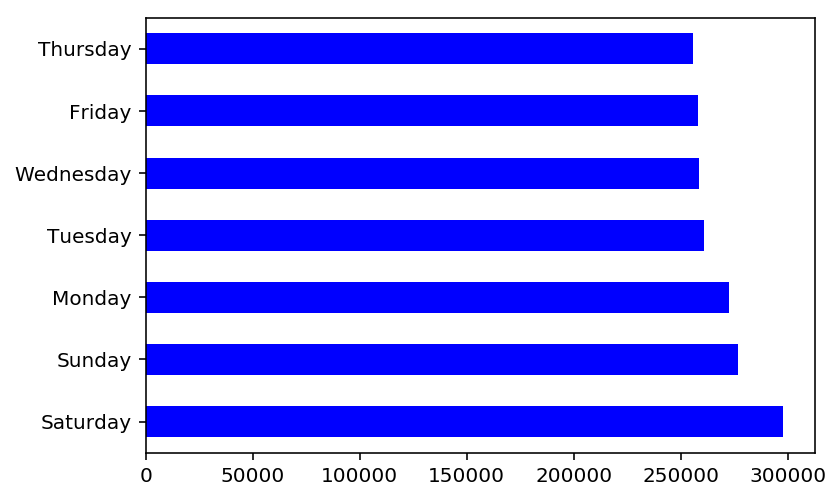

In [128]:
df['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='blue')
plt.show()

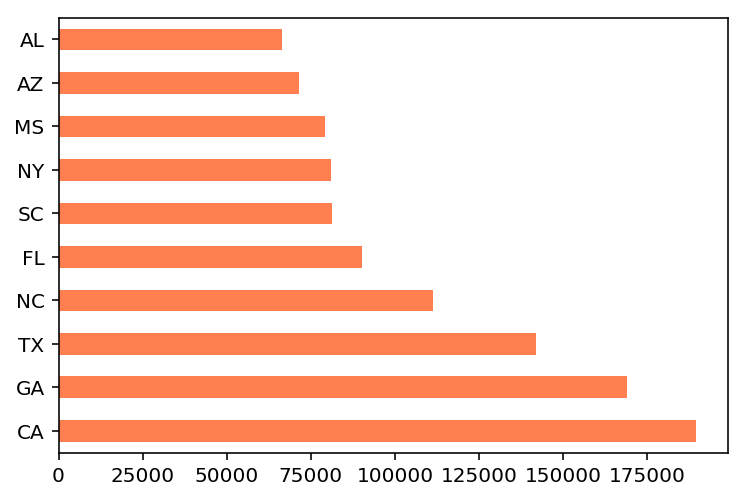

In [129]:
df['STATE'].value_counts().head(n=10).plot(kind='barh',color='coral')
plt.show()

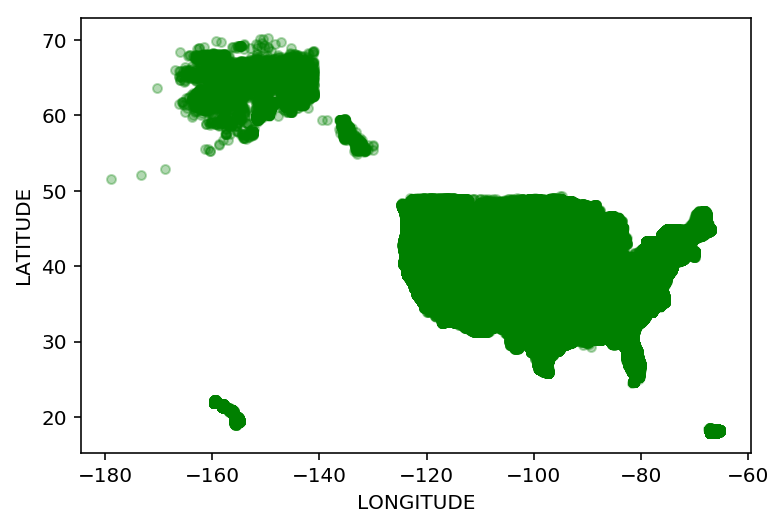

In [131]:
df.plot(kind='scatter',x='LONGITUDE',y='LATITUDE',color='green',alpha=0.3)
plt.show()

## Modeling

In [12]:
def set_label(cat):
    cause = 0
    natural = ['Lightning']
    accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    malicious = ['Arson']
    other = ['Missing/Undefined','Miscellaneous']
    if cat in natural:
        cause = 1
    elif cat in accidental:
        cause = 2
    elif cat in malicious:
        cause = 3
    else:
        cause = 4
    return cause

def set_label(cat):
    cause = 0
    natural = ['Lightning']
    accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    malicious = ['Arson']
    other = ['Missing/Undefined','Miscellaneous']
    if cat in natural:
        cause = 1
    elif cat in accidental:
        cause = 2
    elif cat in malicious:
        cause = 3
    else:
        cause = 4
    return cause

In [56]:
le = LabelEncoder()
df['STATE'] = le.fit_transform(df['STATE'])
df['DAY_OF_WEEK'] = le.fit_transform(df['DAY_OF_WEEK'])
df['LOCATION']=df.LATITUDE*df.LONGITUDE
# df['COMPLEX_NAME'] = pd.factorize(df['COMPLEX_NAME'])
# df['FIRE_YEAR'] = le.fit_transform(df['FIRE_YEAR'])

In [57]:
main=df[['STATE','MONTH','DAY_OF_WEEK','FIRE_YEAR', 'TIME_DISCOVERED', 'FIRE_SIZE', 'DISCOVERY_DOY', 'LOCATION']]
# main['CAUSE'] = pd.factorize(df['STAT_CAUSE_DESCR'])[0] + 1
main['CAUSE'] = df['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x))
main.head()

/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,STATE,MONTH,DAY_OF_WEEK,FIRE_YEAR,TIME_DISCOVERED,FIRE_SIZE,DISCOVERY_DOY,LOCATION,CAUSE
0,4,2,6,2005,46800,0.10,33,-4844.703826,4
1,4,5,6,2004,31500,0.25,133,-4687.712925,1
2,4,5,1,2004,69660,0.10,152,-4706.775021,2
3,4,6,1,2004,57600,0.10,180,-4623.758206,1
4,4,6,1,2004,57600,0.10,180,-4624.518679,1


In [127]:
# sc=StandardScaler()
# sc.fit(df.TIME_DISCOVERED.values)
# df.TIME_DISCOVERED=sc.transform(df.TIME_DISCOVERED)
# df.head()

In [88]:
pd.factorize(df['STAT_CAUSE_DESCR'])

(array([ 0,  1,  2, ..., 12, 12,  0]),
 Index(['Miscellaneous', 'Lightning', 'Debris Burning', 'Campfire',
        'Equipment Use', 'Arson', 'Children', 'Railroad', 'Smoking',
        'Powerline', 'Structure', 'Fireworks', 'Missing/Undefined'],
       dtype='object'))

In [58]:
X=main.iloc[:,:main.shape[1]-1]
Y=main.iloc[:,main.shape[1]-1]

In [59]:
X.head()

,STATE,MONTH,DAY_OF_WEEK,FIRE_YEAR,TIME_DISCOVERED,FIRE_SIZE,DISCOVERY_DOY,LOCATION
0,4,2,6,2005,46800,0.10,33,-4844.703826
1,4,5,6,2004,31500,0.25,133,-4687.712925
2,4,5,1,2004,69660,0.10,152,-4706.775021
3,4,6,1,2004,57600,0.10,180,-4623.758206
4,4,6,1,2004,57600,0.10,180,-4624.518679


In [17]:
def predict_model(model,X,Y, split=0.3,random_state=7):
    
    train_X, test_X, train_Y, test_Y = train_test_split(X,Y, test_size=split, random_state=random_state)
    model.fit(train_X,train_Y)        
    ypred=model.predict(test_X)
#     acc=accuracy_score(test_Y,model.predict(test_X))
    acc=model.score(test_X,test_Y)
    print("Model Report: ", type(model).__name__)
    print("Accuracy: ",acc)
    cm=confusion_matrix(test_Y,ypred)
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
#     print("Confusion Matrix:\n",confmat,"\n\n\n")


Model Report:  LGBMClassifier
Accuracy:  0.5381164250008863


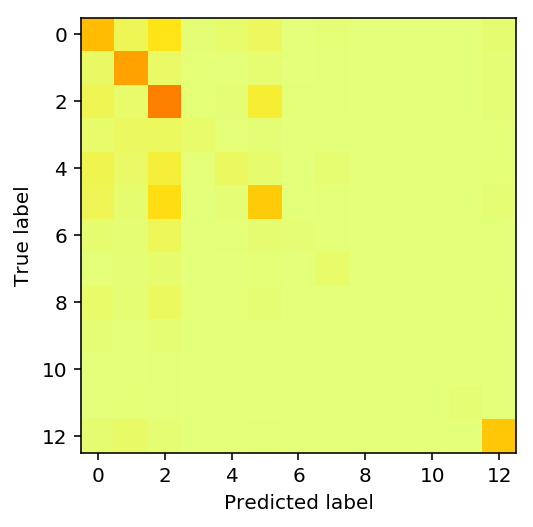

/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model Report:  RandomForestClassifier
Accuracy:  0.5521218137341795


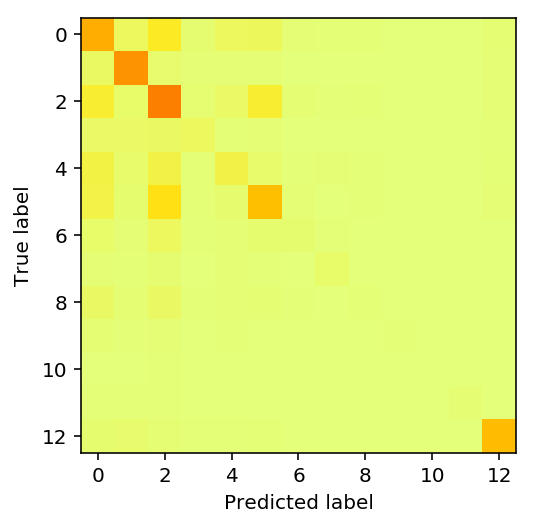

In [15]:
# Testing different models with default hyperparameters - 13 labels
models=[lgb.LGBMClassifier(),RandomForestClassifier()]
for lf in models:
    predict_model(lf,X,Y)

Model Report:  LGBMClassifier
Accuracy:  0.6546920977062431


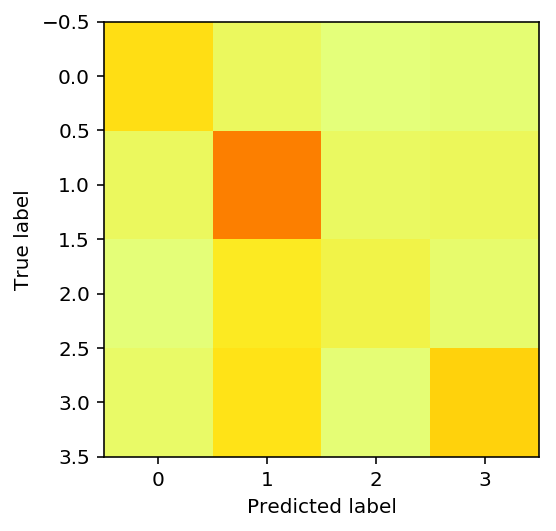

/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model Report:  RandomForestClassifier
Accuracy:  0.6785886482078917


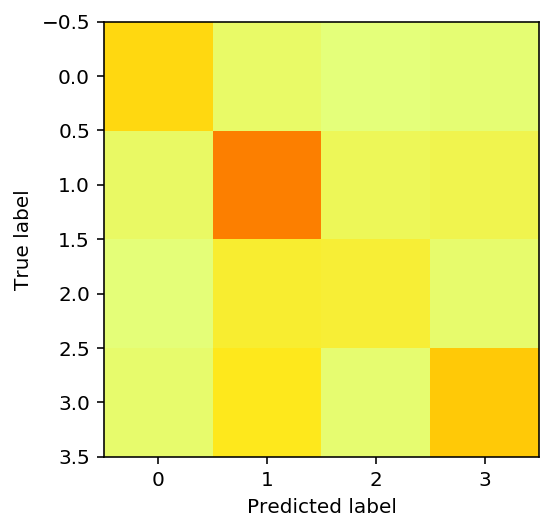

In [19]:
# Testing different models with default hyperparameters - 4 labels
models=[lgb.LGBMClassifier(),RandomForestClassifier()]
for lf in models:
    predict_model(lf,X,Y)

Model Report:  LGBMClassifier
Accuracy:  0.6655014712659978


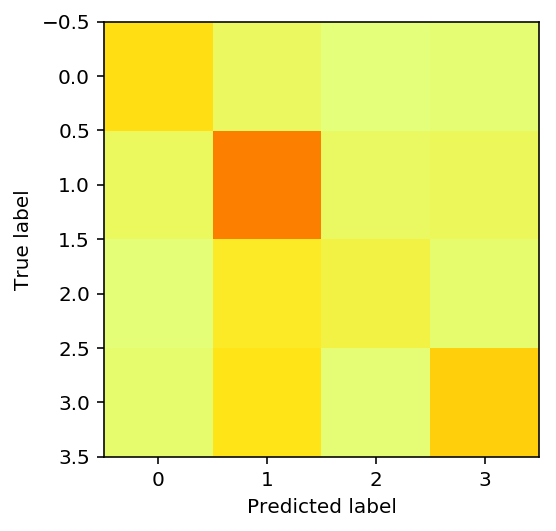

/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model Report:  RandomForestClassifier
Accuracy:  0.6925709930159181


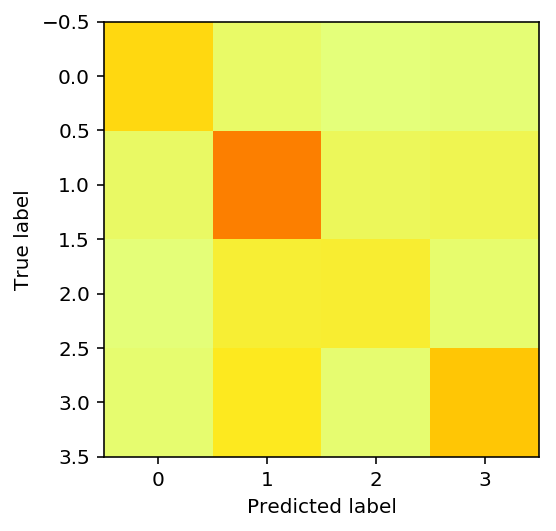

In [132]:
# Testing different models with default hyperparameters - 4 labels
models=[lgb.LGBMClassifier(),RandomForestClassifier()]
for lf in models:
    predict_model(lf,X,Y)

Model Report:  LGBMClassifier
Accuracy:  0.6655014712659978


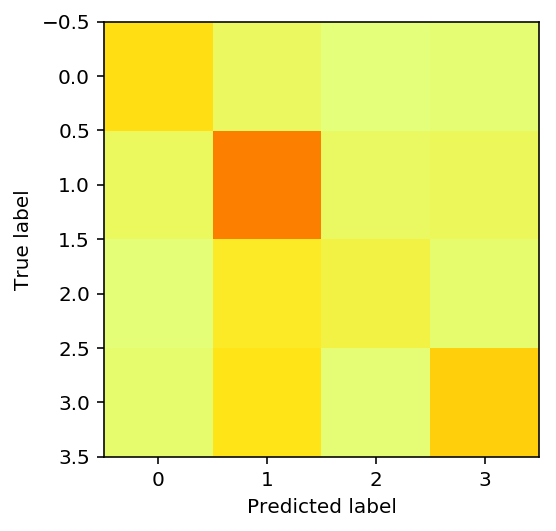

/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model Report:  RandomForestClassifier
Accuracy:  0.6930921402488744


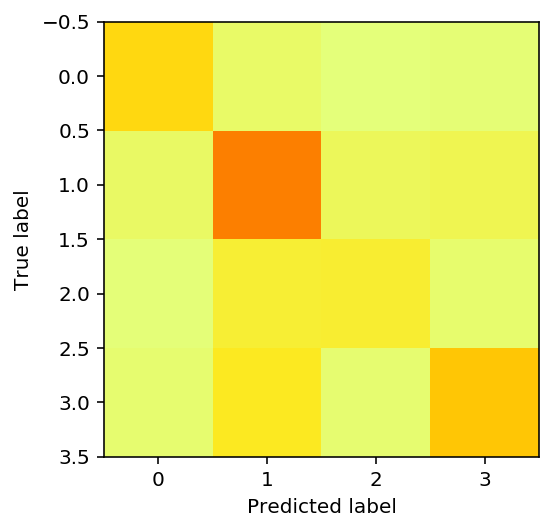

Model Report:  GradientBoostingClassifier
Accuracy:  0.617401708795689


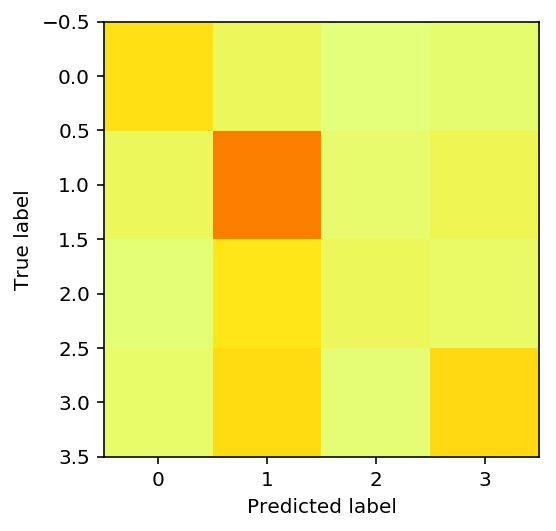

In [201]:
# Testing different models with default hyperparameters - 4 labels
models=[lgb.LGBMClassifier(),RandomForestClassifier(), GradientBoostingClassifier()]
for lf in models:
    predict_model(lf,X,Y)

## Tuning


In [17]:
# bootstrap=True, class_weight=None, criterion='gini',
# max_depth=None, max_features='auto', max_leaf_nodes=None,
# min_impurity_decrease=0.0, min_impurity_split=None,
# min_samples_leaf=1, min_samples_split=2,
# min_weight_fraction_leaf=0.0, n_estimators=10,
# n_jobs=None, oob_score=False, random_state=7, verbose=0,
# warm_start=False

def predict_GridCV(model,params,train_X,train_Y, test_X, test_Y):
    clf=GridSearchCV(model, params, cv=2, scoring='accuracy', verbose=1,n_jobs=-1)
    clf.fit(train_X,train_Y)
    ypred=clf.predict(test_X)

    print(clf.best_params_)
    print(clf.best_score_)
    print()
    print("acc: ",accuracy_score(test_Y,ypred))


Model Report:  RandomForestClassifier
Accuracy:  0.6844822956024175


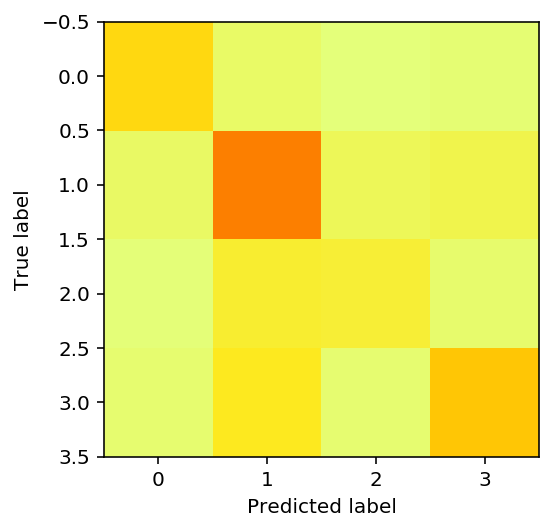

In [71]:
X_train,X_test,Y_train,Y_test = train_test_split(X.values,Y.values, test_size=0.2, random_state=7)
l=RandomForestClassifier(criterion='gini', n_estimators=150)
predict_model(l,X,Y,0.2)

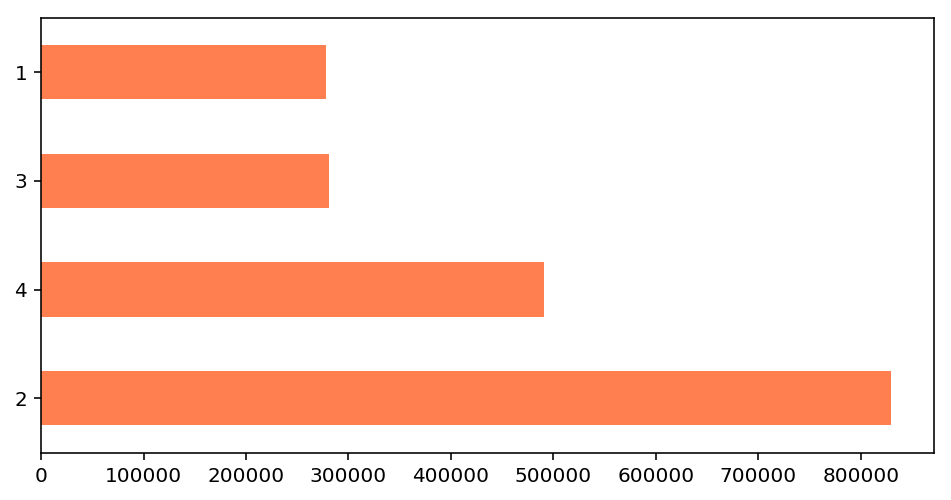

In [69]:
plt.figure(figsize=(8,4))
main['CAUSE'].value_counts().plot(kind='barh',color='coral')
plt.show()

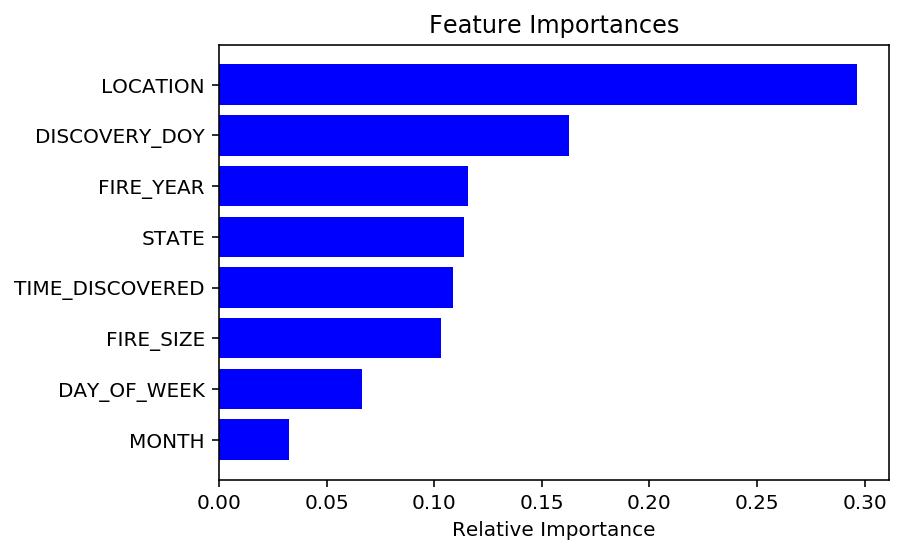

In [62]:
l=RandomForestClassifier(criterion='gini', n_estimators=5)
l.fit(X_train,Y_train)
features = X.columns
importances = l.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [54]:
importances

array([0.06534105, 0.04212454, 0.05495662, 0.1165276 , 0.08978042,
       0.07808508, 0.12619983, 0.19200923, 0.23497563])

In [25]:
print(accuracy_score(Y_test, l.predict(X_test)))

0.6938283881912186


In [ ]:
0.7202314321191833

In [ ]:
# Tuning RandomForestClassifier
parameters={
                "max_depth":[None],
                "n_estimators":[200,500],
                "criterion":['gini']
                
}


lf=RandomForestClassifier(random_state=1)
predict_GridCV(lf,parameters,X_train,Y_train,X_test,Y_test)

In [25]:
df_CA=df.copy()
df_CA = df_CA[['STATE','DAY_OF_WEEK','FIRE_YEAR', 'TIME_DISCOVERED', 'FIRE_SIZE', 'DISCOVERY_DOY', 'LATITUDE','LONGITUDE','STAT_CAUSE_DESCR']]
df_CA['LOCATION']=df_CA.LATITUDE*df_CA.LONGITUDE
df_CA = df_CA.dropna()
df_CA['CAUSE'] = df_CA['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x))
df_CA.drop(['STAT_CAUSE_DESCR','LATITUDE','LONGITUDE'], axis=1, inplace=True)
df_CA.head()

,STATE,DAY_OF_WEEK,FIRE_YEAR,TIME_DISCOVERED,FIRE_SIZE,DISCOVERY_DOY,LOCATION,CAUSE
0,4,6,2005,46800,0.10,33,-4844.703826,4
1,4,6,2004,31500,0.25,133,-4687.712925,1
2,4,1,2004,69660,0.10,152,-4706.775021,2
3,4,1,2004,57600,0.10,180,-4623.758206,1
4,4,1,2004,57600,0.10,180,-4624.518679,1


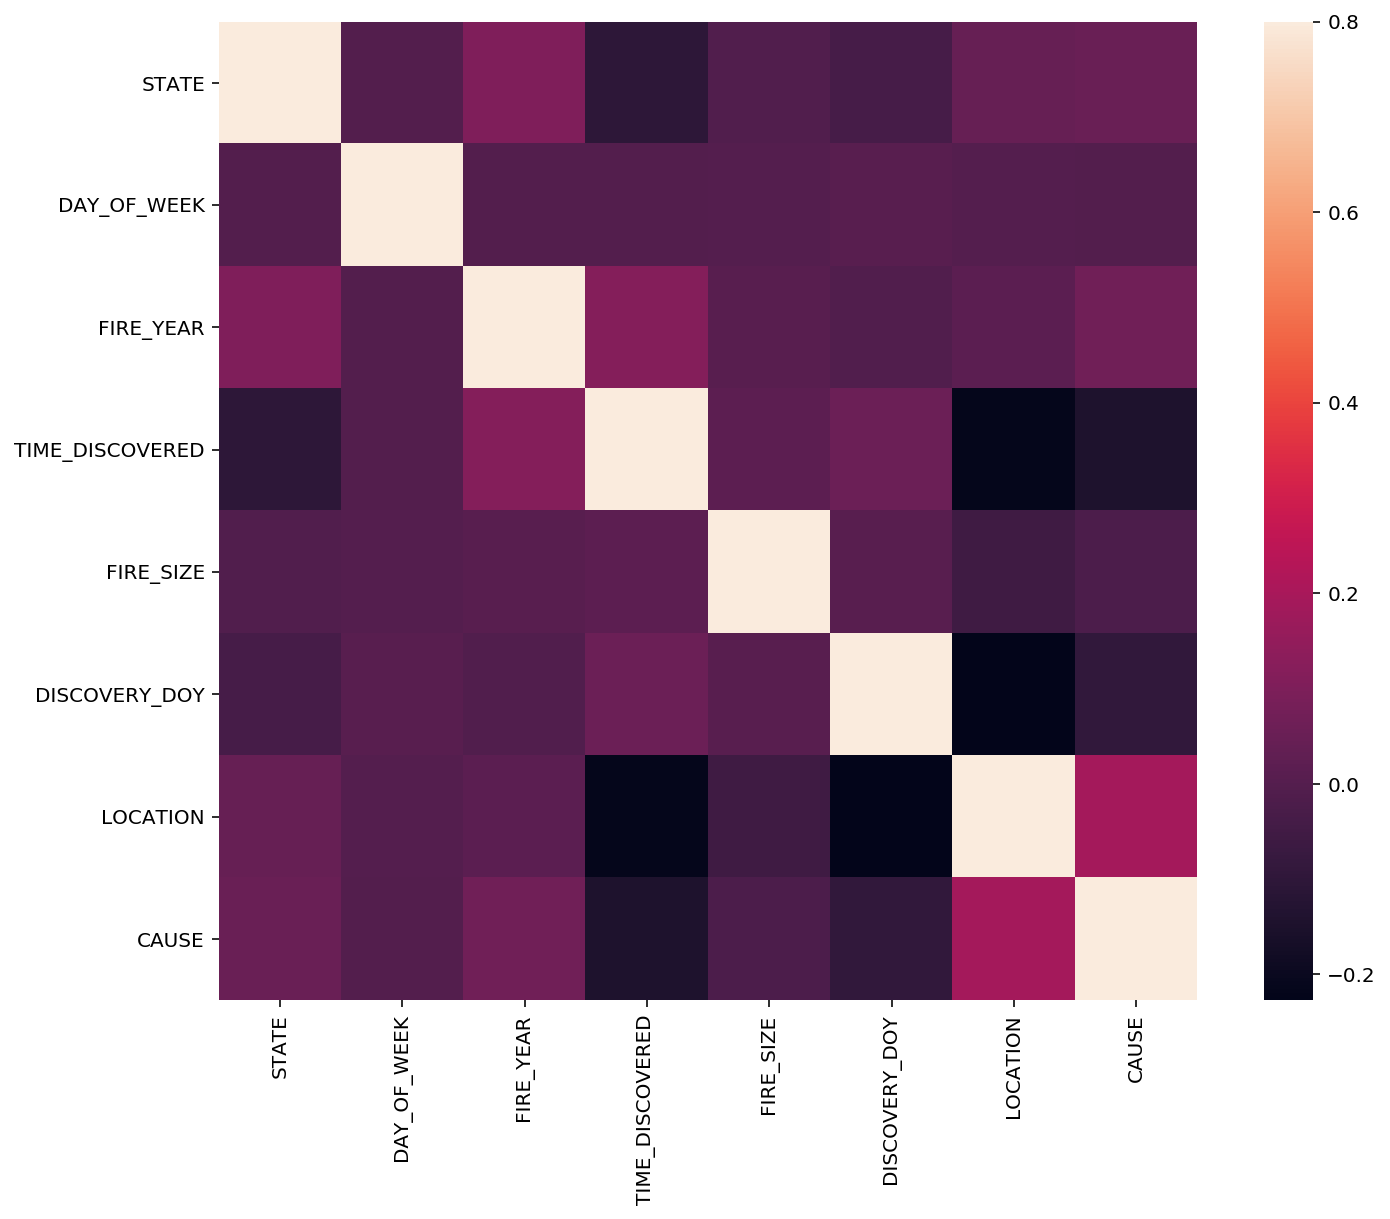

In [26]:
corrmat = df_CA.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model Report:  RandomForestClassifier
Accuracy:  0.6598308930407346


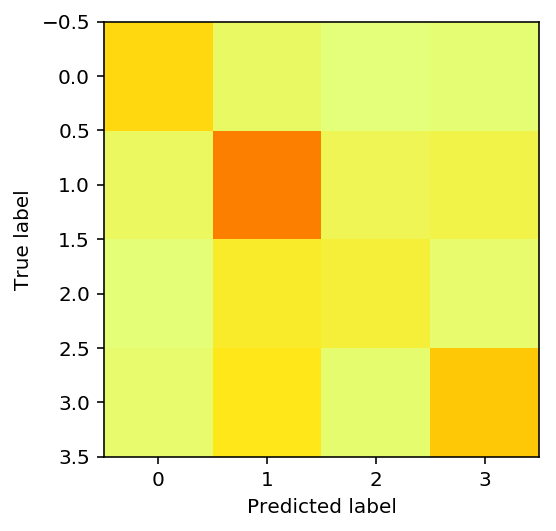

In [191]:
# Testing different models with default hyperparameters - 4 labels
X=df_CA.iloc[:,:df_CA.shape[1]-1].values
Y=df_CA.iloc[:,df_CA.shape[1]-1].values

sc=StandardScaler()
sc.fit(X)
x_std=sc.transform(X)

models=[RandomForestClassifier(max_features=2)]
for lf in models:
    predict_model(lf,x_std,Y)

### Neural Network

In [209]:
targets = main.columns[main.shape[1]-1:main.shape[1]]
train_X, test_X, train_Y, test_Y = train_test_split(X,Y, test_size=0.3, random_state=7)



In [236]:
num_training_indices

1316325

In [238]:
indices = list(range(main.shape[0]))
num_training_indices = int(0.7 * main.shape[0])
np.random.shuffle(indices)
train_indices = indices[:num_training_indices]
test_indices = indices[num_training_indices:]

train = main.iloc[train_indices]
test = main.iloc[test_indices]

In [257]:
train_X = train.drop('CAUSE', axis=1)
train_y = train['CAUSE']

val_X = test.drop('CAUSE', axis=1)
val_y = test['CAUSE']

model = Sequential([
    Dense(128, input_shape=(train_X.shape[1],)),
    Dense(1),
    Activation('sigmoid'),
])
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
model.compile(optimizer='adam', loss='binary_crossentropy')

model.fit(train_X, train_y, epochs = 30, validation_data=(val_X, val_y), callbacks = [es])
preds = model.predict(val_X)

acc_neural= accuracy_score(val_y,preds)

print("\n\nFinal Accuracy: ",acc_neural)

Train on 1316325 samples, validate on 564140 samples
Epoch 1/30
1316325/1316325 [==============================] - 43s 32us/step - loss: -727201471.5939 - val_loss: -2067719422.8038
Epoch 2/30
1316325/1316325 [==============================] - 43s 33us/step - loss: -4601450617.7046 - val_loss: -7713688176.4269
Epoch 3/30
1316325/1316325 [==============================] - 42s 32us/step - loss: -12012116385.6072 - val_loss: -16872498161.2537
Epoch 4/30
1316325/1316325 [==============================] - 43s 32us/step - loss: -22933645034.2549 - val_loss: -29532248781.8419
Epoch 5/30
1316325/1316325 [==============================] - 42s 32us/step - loss: -37354096096.8088 - val_loss: -45689348260.2931
Epoch 6/30
1316325/1316325 [==============================] - 43s 32us/step - loss: -55279734698.0892 - val_loss: -65340429463.7250
Epoch 7/30
1316325/1316325 [==============================] - 42s 32us/step - loss: -76693597916.5883 - val_loss: -88472509916.4920
Epoch 8/30
1316325/1316325 [